In [1]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
from scipy import stats
from scipy import fftpack
import itertools

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities import utilities as utils

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def apply_notch_60Hz(data, sample_rate):
    '''
    Applies a notch filter to remove 60 Hz line noise.
    
    Inputs:
    -------
    data -- nd.array, (samples, channels)
    sample_rate -- int, Hz
    
    Outputs:
    --------
    filtered_data -- nd.array, (samples, channels)
    '''
    notch_freq = 60

    # initialize filtered signal
    filtered_data = data

    # create filter kernel using firwin
    frange = [notch_freq-0.5, notch_freq+0.5]
    order  = int(150*(sample_rate/frange[0]))
    order  = order + ~order%2

    # filter kernel
    filtkern = signal.firwin(order, frange, pass_zero=True, fs=sample_rate)

    # recursively apply to data
    filtered_data = signal.filtfilt(filtkern, 1, filtered_data, axis=0)
    
    return filtered_data

In [6]:
def rolling_corr(x, y, timestamps, window_length=1000, overlap=500):
    '''
    Calculates the pairwise correlation between x and y in overlapping windows.
    
    Inputs:
    -------
    x, y -- data, 1d array
    timestamps -- timestamps for x, y, 1d array
    window_length -- number of samples to perform correlation over, int (default=1000)
    overlap -- number of samples to overlap, int (default=500)
    
    Outputs:
    --------
    rolling_corr -- correlation of x, y over time
    rolling_pval -- 
    rolling_ts -- 
    '''
    
    # indices of windows
    window_starts = np.arange(0, np.shape(x)[0], window_length-overlap)[:-1]
    
    # initialize arrays
    rolling_corr = np.zeros(len(window_starts))
    rolling_pval = np.zeros(len(window_starts))
    rolling_ts = np.zeros(len(window_starts))
    
    # loop through window_starts and calculate Pearson's correlation
    for ind, beg in enumerate(window_starts):
        end = beg + window_length
        mid = int((beg + end)/2)
        rolling_corr[ind], rolling_pval[ind] = stats.pearsonr(x[beg:end], y[beg:end])
        rolling_ts[ind] = timestamps[mid]
        
    return rolling_corr, rolling_pval, rolling_ts

In [7]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

### List of experiment folders

In [8]:
experiments = [r'E:\eeg_pilot\mouse496220\pilot1_2020-01-10\recording1',
               r'E:\eeg_pilot\mouse496220\pilot2_2020-01-16\recording1',
               r'E:\eeg_pilot\mouse497154\pilot1_2019-12-24\recording1',
               r'E:\eeg_pilot\mouse497154\pilot2_2020-01-15\recording1',
               r'E:\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1',
               r'E:\eeg_pilot\mouse507190\pilot1_2020-02-28_10-33-11\recording1'
              ]

##### Some constants:

In [9]:
sample_rate = 2500

In [10]:
# make a color list for plotting later
session_colors = cm.rainbow(np.linspace(0, 1, len(experiments)))

#### Start looping through data to load eeg, filter, and calculate pairwise distances and correlations.

In [11]:
all_mice_corrdf = {}
for folder in experiments:
    exp = EEGexp(folder)
    
    # get date (Jan05) to be used in distinguishing mice with multiple sessions
    exp_date = datetime.strptime(exp.data_folder[exp.data_folder.find('\pilot')+8:exp.data_folder.find('\pilot')+18],
                                 '%Y-%m-%d').strftime('%b%d')
    print('Mouse %s, %s' % (exp.mouse, exp_date))
    session = exp.mouse + '_' + exp_date
    
    # load eeg data
    eegdata, timestamps = exp.load_eegdata(frequency=sample_rate, return_type='np')
    eegdata = eegdata * exp.bits_to_uvolts # IS THIS NECESSARY WITH NEW PROCESSING??
    print('Recording duration: %0.1f minutes' % (np.shape(eegdata)[0]/sample_rate/60))
    
    # apply notch filter
    filteeg = apply_notch_60Hz(eegdata, sample_rate)
    
    # apply lowpass filter
    filter_kernel = lowpass_filt_design(len(timestamps), sample_rate)
    filteeg = signal.filtfilt(filter_kernel, 1, filteeg, axis=0)
    
    # loop through unique channel pairs, find distance and correlation
    dist = []
    r_value = []
    p_value = []

    for a, b in itertools.combinations(exp.ch_coordinates.index.values, 2):

        # calculate distance between ch a and b
        dist.append(np.sqrt((exp.ch_coordinates.AP.iloc[a]-exp.ch_coordinates.AP.iloc[b])**2
                            + (exp.ch_coordinates.ML.iloc[a]-exp.ch_coordinates.ML.iloc[b])**2))

        # calculate the Pearson's correlation between the filtered EEG data for ch a and b
        temp_r, temp_p = stats.pearsonr(filteeg[:,a], filteeg[:,b])
        r_value.append(temp_r)
        p_value.append(temp_p)
    
    # make into dataframe
    ch_combos = pd.DataFrame({
        'distance': dist,
        'r_value': r_value,
        'p_value': p_value,
    })
    
    # save each session dataframe to dictionary
    all_mice_corrdf[session] = ch_combos
    
    # delete large arrays
    del eegdata, timestamps, filteeg

Mouse 496220, Jan10
Recording duration: 46.6 minutes
Mouse 496220, Jan16
Recording duration: 55.1 minutes
sslog_file not found.
Mouse 497154, Dec24
Recording duration: 15.5 minutes
Mouse 497154, Jan15
Recording duration: 57.9 minutes
Mouse 505550, Mar02
Recording duration: 50.5 minutes
Mouse 507190, Feb28
Recording duration: 60.2 minutes


### Now we have a dictionary of all the pairwise correlations for each session. Let's loop through to bin and average values for each session. Also, calculate the linear regression.

<IPython.core.display.Javascript object>


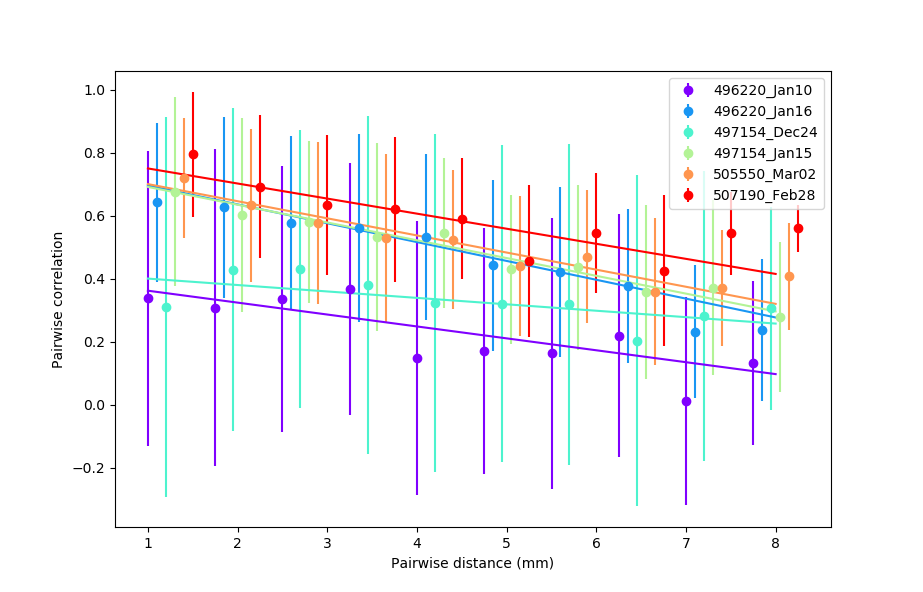

In [12]:
fig, ax = plt.subplots()
x_offset = 0.1
for i, (key, df) in enumerate(all_mice_corrdf.items()):
    
    # find binned average correlation and std
    mean_corr, dist_bin, bn = stats.binned_statistic(df.distance.to_numpy(), df.r_value.to_numpy(), statistic='mean')
    std_corr, db, bn = stats.binned_statistic(df.distance.to_numpy(), df.r_value.to_numpy(), statistic='std')
    lr_m, lr_b, lr_r, lr_p, lr_ste = stats.linregress(df.distance.to_numpy(), df.r_value.to_numpy())
    
    # plot binned correlation values with std
    ax.errorbar(dist_bin[:-1]+(x_offset*i),
                mean_corr, yerr=std_corr,
                color=session_colors[i],
                marker='o',
                linestyle='none',
                label=key
               )

    # plot linear regression
    xdist = np.arange(dist_bin[0], dist_bin[-1])
    ax.plot(xdist, lr_m * xdist + lr_b, color=session_colors[i], linestyle='solid')
    
ax.set_xlabel('Pairwise distance (mm)')
ax.set_ylabel('Pairwise correlation')
ax.legend()

### To do analysis for an individual session use data_cleaning.ipynb (or only put one mouse in list).